In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from config import *
from nerf import *
from camera_operations import *
from dataset import *

using device: cuda
Train Images Shape: (100, 100, 100, 3)
Train Poses Shape: (100, 4, 4)
Validation Image Shape: (100, 100, 3)
Validation Pose Shape: (4, 4)
Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal value: 138.88888
x-fov: 39.597755335771296
y-fov: 39.597755335771296


c:\Users\Mathis\.conda\envs\ProjetTunnel\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\Mathis\Desktop\Vision-Neural_Radiance_Fields\camera_operations.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, device = device, dtype = dtype)
c:\Users\Mathis\Desktop\Vision-Neural_Radiance_Fields\camera_operations.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v 

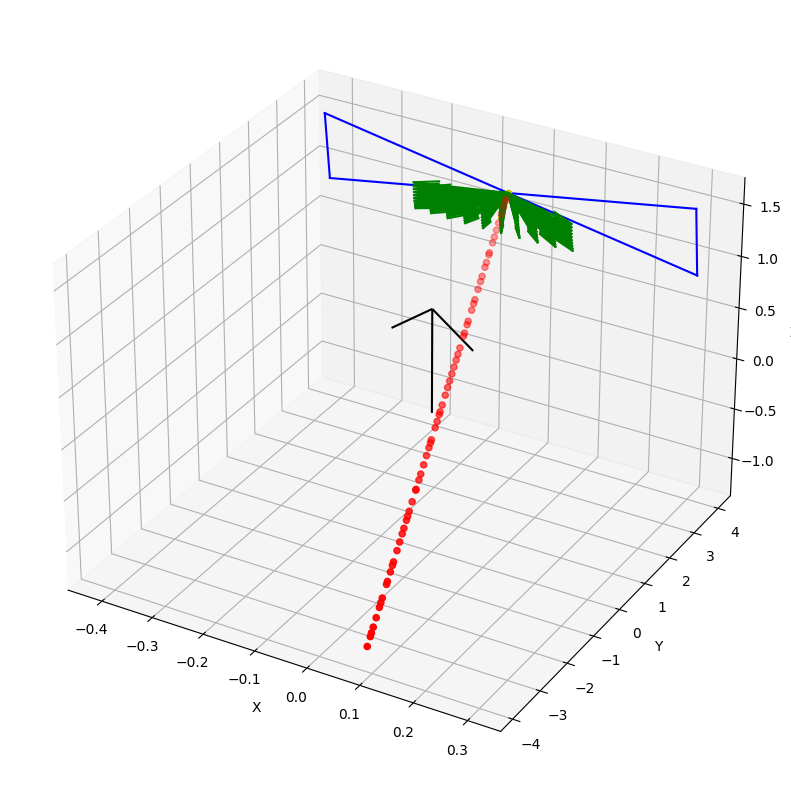

In [2]:
u, v = torch.meshgrid(torch.linspace(-image_height/2, image_width/2, image_height), torch.linspace(-image_width/2, image_width/2, image_width))
ds = extract_origin_and_direction(torch.Tensor(train_poses).to(device), u, v, camera_instrinsics)[:,:,0,3:]


# 3D plot of the camera positions
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(train_poses[:, 0, 3].cpu(), train_poses[:, 1, 3].cpu(), train_poses[:, 2, 3].cpu())
# for i in range(0, train_poses.shape[0]):
#     ax.quiver(train_poses[i, 0, 3].cpu(), train_poses[i, 1, 3].cpu(), train_poses[i, 2, 3].cpu(), -train_poses[i, 0, 2].cpu(), -train_poses[i, 1, 2].cpu(), -train_poses[i, 2, 2].cpu(), length=0.5, normalize=True, color='r')

# we now plot only the first camera pose, in yellow
ax.scatter(train_poses[0, 0, 3].cpu(), train_poses[0, 1, 3].cpu(), train_poses[0, 2, 3].cpu(), color='y')
ax.quiver(train_poses[0, 0, 3].cpu(), train_poses[0, 1, 3].cpu(), train_poses[0, 2, 3].cpu(), -train_poses[0, 0, 2].cpu(), -train_poses[0, 1, 2].cpu(), -train_poses[0, 2, 2].cpu(), length=0.5, normalize=True, color='y')


# black box at the origin for reference, length 1
ax.quiver(0, 0, 0, 0, 0, 1, length=1, normalize=True, color='k')

# for first camera pose, plot the image plane
# 4 corners of the image plane
dc = image_width / (2 * f)

corners = torch.tensor([[-dc, -dc, 0, 1], [-dc, dc, -0, 1], [dc, dc, -0, 1], [dc, -dc, -0, 1]], device = device, dtype = dtype)
corners = train_poses[0] @ corners.t()
corners = corners[:3] / corners[3]
corners = corners.t().cpu().numpy()
# connect the corners
ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], [corners[0, 2], corners[1, 2]], color='b')
ax.plot([corners[1, 0], corners[3, 0]], [corners[1, 1], corners[3, 1]], [corners[1, 2], corners[3, 2]], color='b')
ax.plot([corners[3, 0], corners[2, 0]], [corners[3, 1], corners[2, 1]], [corners[3, 2], corners[2, 2]], color='b')
ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], [corners[2, 2], corners[0, 2]], color='b')

# quiver plot of the pixel rays
for i in range(0, image_height, 10):
    for j in range(0, image_width, 10):
        ax.quiver(train_poses[0, 0, 3].cpu(), train_poses[0, 1, 3].cpu(), train_poses[0, 2, 3].cpu(), ds[i, j, 0].cpu(), ds[i, j, 1].cpu(), ds[i, j, 2].cpu(), length=0.5, normalize=True, color='g')

# plot a sample pixel ray
sampler = CoarseNeRFSampler(t_max=8)
ts = sampler.sample(train_poses[0, :3, 3], ds[50, 50])
xs = train_poses[0, :3, 3].cpu() + ds[50, 50].cpu() * ts[:, None].cpu()
xs = xs.cpu().numpy()
ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


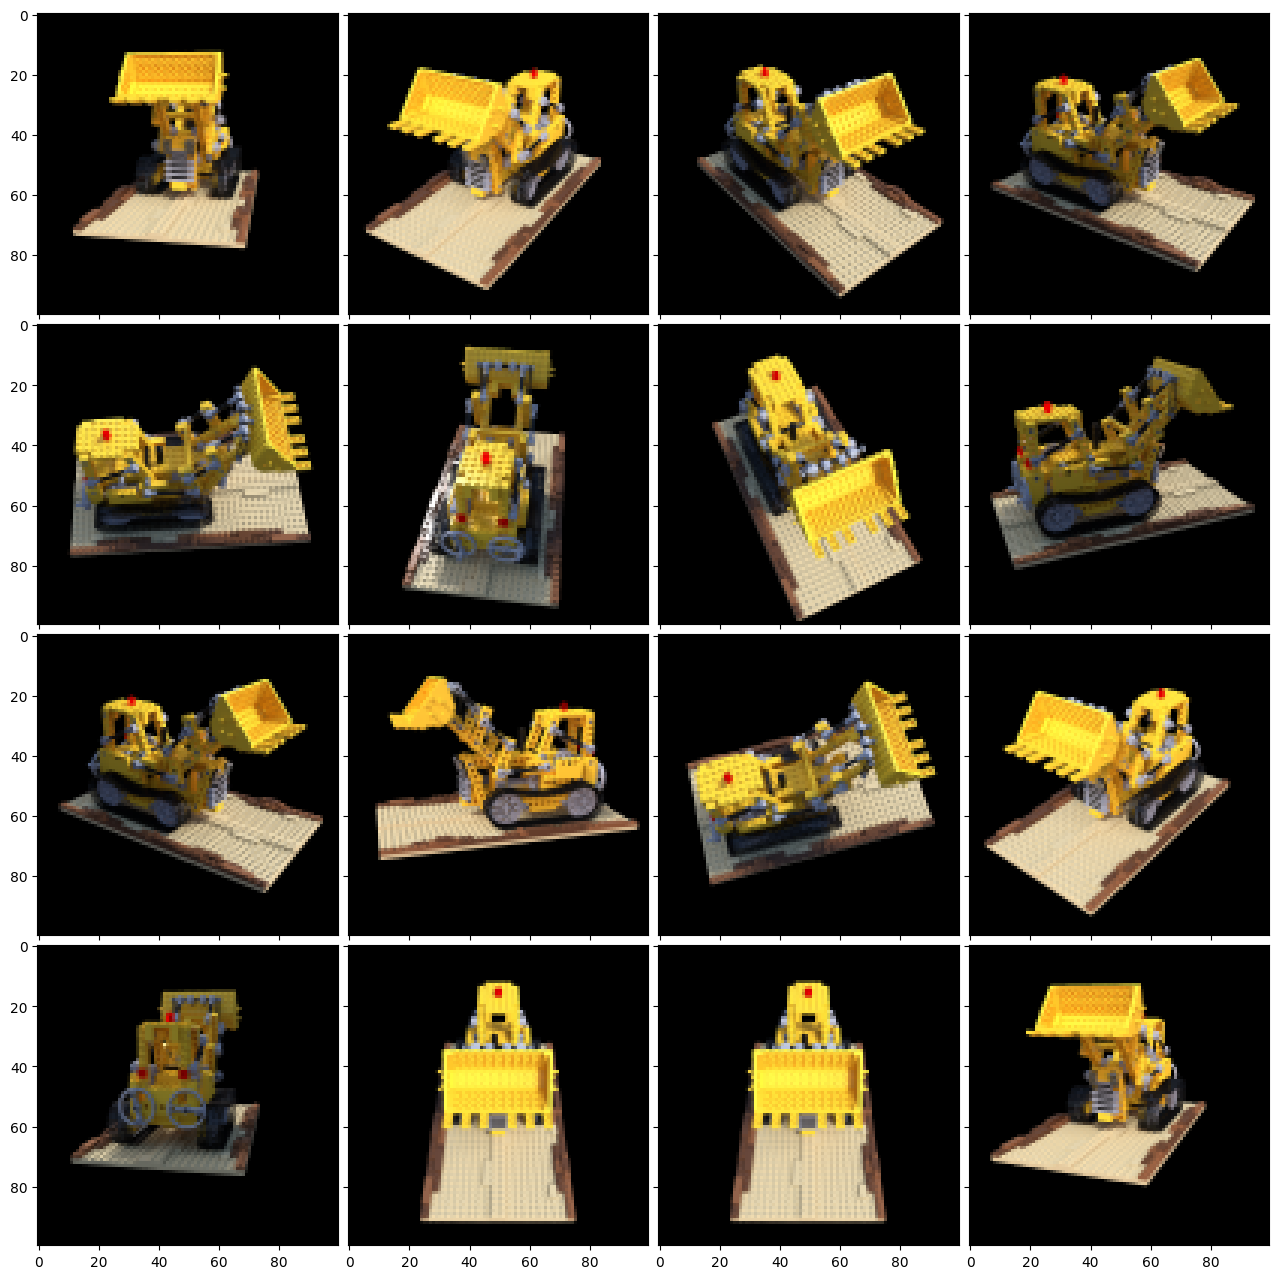

In [3]:
show_dataset()

In [4]:
coarse_sampler = CoarseNeRFSampler(t_min=0, t_max=8, Nc=64) 
coarse_model = NeRF(hidden_dim=128, sampler=coarse_sampler, name="coarse_128").to(device = device ,dtype=dtype)
coarse_model.train_model(train_poses, train_images)  # saves the model each 5 epochs, automatically

Preprocessing ...
Training the model ...


c:\Users\Mathis\Desktop\Vision-Neural_Radiance_Fields\camera_operations.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, device = device, dtype = dtype)
c:\Users\Mathis\Desktop\Vision-Neural_Radiance_Fields\camera_operations.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v, device = device, dtype = dtype)


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


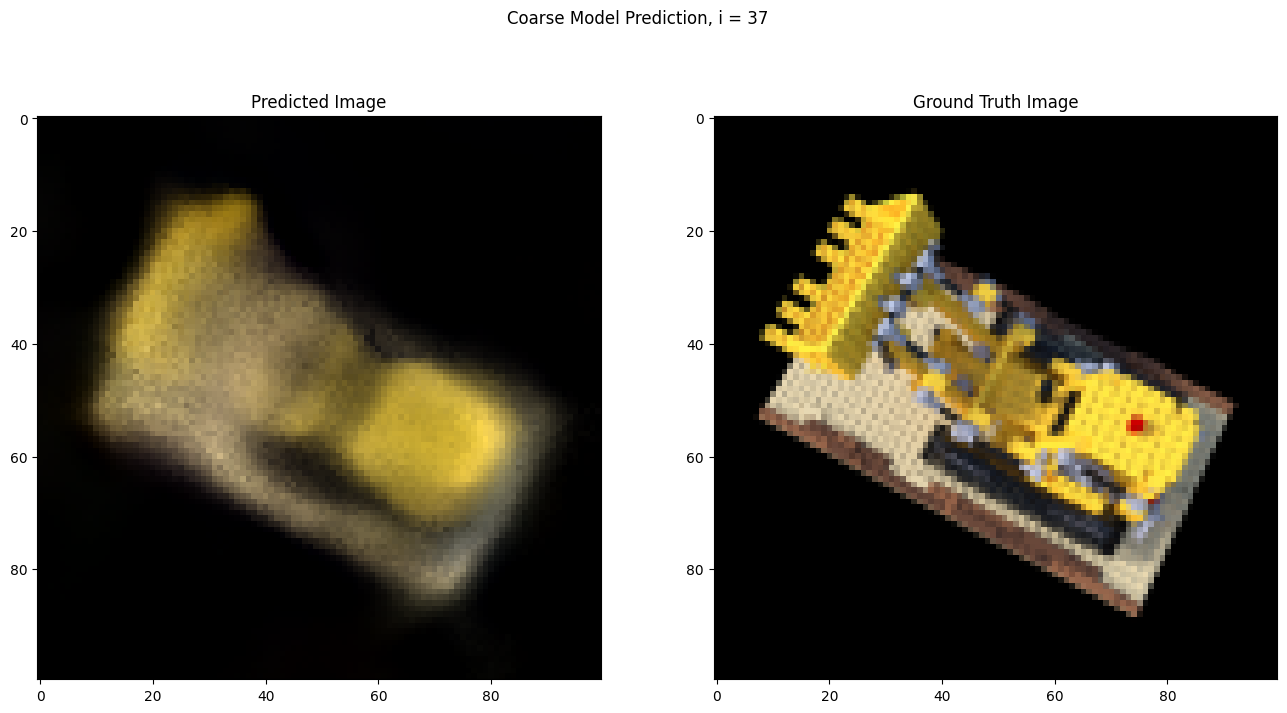

In [7]:
# try to reconstruct the image from the validation pose
coarse_model.eval()
i = np.random.randint(0, len(train_poses))
predicted_image = coarse_model.predict_scene(train_poses[i])
predicted_image = predicted_image.detach().cpu().numpy()
predicted_image = predicted_image / np.max(predicted_image)
predicted_image = predicted_image
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(predicted_image)
plt.title("Predicted Image")

plt.subplot(1, 2, 2)
plt.imshow(train_images[i].cpu().numpy())
plt.title("Ground Truth Image")
plt.suptitle("Coarse Model Prediction, i = " + str(i))
plt.show()
